In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread, imshow
import keras.backend as K

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
BATCH_SIZE = 1
NUM_EPOCHS = 4
IMAGE_SIZE = (256, 256)

In [3]:
train_dir = './dataset/train'
train_dataset = image_dataset_from_directory(train_dir, label_mode=None, shuffle=False, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

validation_dir = './dataset/validation'
validation_dataset = image_dataset_from_directory(validation_dir, label_mode=None, shuffle=False, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

test_dir = './dataset/test'
test_dataset = image_dataset_from_directory(test_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


(1, 256, 256, 3)


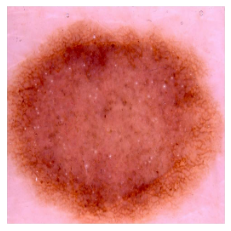

In [4]:
for images in train_dataset.take(1):
    print(images.shape)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
from model import ImageColorizationModel
from freeze import Freezer
model = ImageColorizationModel().model()


In [7]:
# model.load_weights('convertedWeights.h5', by_name=True)

In [20]:
delta = 1
def l_delta_loss(y_true, y_pred):
    smaller = K.cast(K.abs(y_true - y_pred) < delta, tf.float32)
    bigger = 1 - smaller
    loss = K.sum(smaller * K.square(y_true - y_pred)) / 2 + delta * K.sum(bigger * (K.abs(y_true - y_pred) - (delta / 2)))
    return loss
def PSNR(y_true, y_pred):
    return tf.image.psnr(a=y_true, b=y_pred, max_val=2)

In [10]:
base_learning_rate = 0.001
model.compile(loss=l_delta_loss,
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy', PSNR, tf.compat.v1.losses.huber_loss])

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bw_conv1_1 (Conv2D)             (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
ab_conv1_1 (Conv2D)             (None, 256, 256, 64) 1792        input_1[0][0]                    
_______________________________________________________________________________________

In [12]:
from utils.data_generator import DataGenerator

In [13]:
train_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=train_dataset, name='train')
validation_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=validation_dataset, name='validation')

In [180]:
train_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
    ),
]

In [ ]:
history = model.fit(train_generator, epochs=100, batch_size=BATCH_SIZE, callbacks=train_callbacks, validation_data=validation_generator)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 203.6241 - accuracy: 0.9746 - PSNR: 31.0971 - huber_loss: 0.0016 - val_loss: 762.1515 - val_accuracy: 0.9828 - val_PSNR: 25.3650 - val_huber_loss: 0.0058
Epoch 2/100


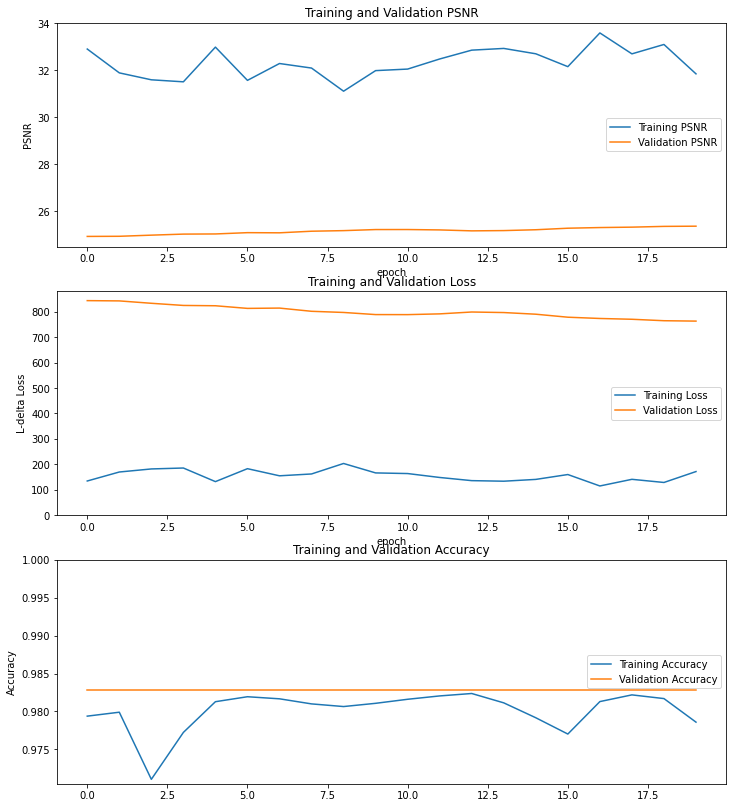

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

psnr = history.history['PSNR']
val_psnr = history.history['val_PSNR']


plt.figure(figsize=(12, 14))


plt.subplot(3, 1, 1)
plt.plot(psnr, label='Training PSNR')
plt.plot(val_psnr, label='Validation PSNR')
plt.legend(loc='right')
plt.ylabel('PSNR')
plt.title('Training and Validation PSNR')
plt.xlabel('epoch')


plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='right')
plt.ylabel('L-delta Loss')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


plt.subplot(3, 1, 3)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

In [169]:
test_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=test_dataset)
test_batch = test_generator.__getitem__(0)
# do your magic vanka

In [175]:
test_batch[0][1][0] = np.dstack((np.ones((256,256,1)), test_batch[1][0]))

predictions = model.predict_on_batch(test_batch)

In [176]:
print(test_batch[0][0].shape)
final_image = np.dstack((test_batch[0][0][0] * 100, predictions[0] * 128))
original_image = np.dstack((test_batch[0][0][0] * 100, test_batch[1][0] * 128))
print(original_image.shape)
print(np.amin(predictions[0] * 128), np.amax(predictions[0] * 128))
print(np.amin( test_batch[1][0] * 128), np.amax( test_batch[1][0] * 128))
print(np.sum((final_image-original_image)))

(1, 256, 256, 1)
(256, 256, 3)
-12.190014 71.34776
-14.050018 57.074356
-1895835.0


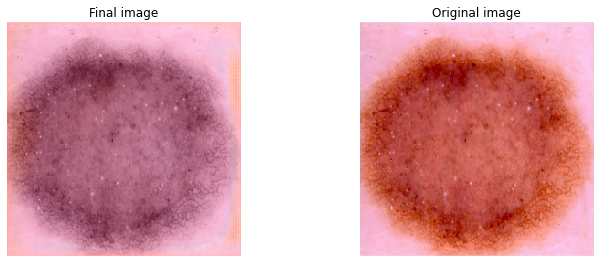

In [177]:
fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize=(12, 4))
imshow(lab2rgb(final_image), ax=ax0), ax0.set_title('Final image'), ax0.axis('off')
imshow(lab2rgb(original_image), ax=ax1), ax1.set_title('Original image'), ax1.axis('off')
plt.show()

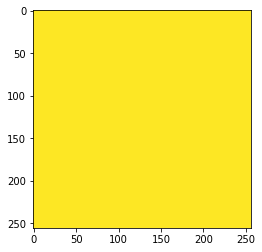

In [178]:
plt.imshow(test_batch[0][1][0][:, :, 0], vmin=0, vmax=1)
plt.show()

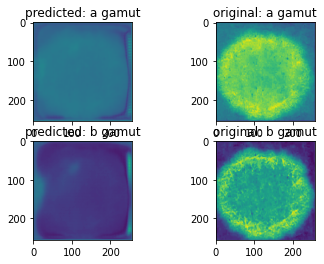

In [179]:
f = plt.figure()

f.add_subplot(2, 2, 1)
plt.title('predicted: a gamut')
plt.imshow(final_image[..., 1])

f.add_subplot(2, 2, 2)
plt.title('original: a gamut')
plt.imshow(original_image[..., 1])

f.add_subplot(2, 2, 3)
plt.title('predicted: b gamut')
plt.imshow(final_image[..., 2])

f.add_subplot(2, 2, 4)
plt.title('original: b gamut')
plt.imshow(original_image[..., 2])

plt.show()

In [131]:
PSNR(original_image[..., 1:3] / 128, final_image[..., 1:3] / 128)

<tf.Tensor: shape=(), dtype=float32, numpy=24.512156>

In [124]:
flattened = np.reshape(final_image[..., 1:3], (256*256*2))
np.sum(flattened == -128)

0

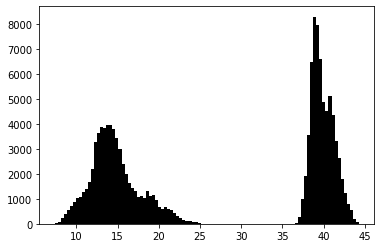

In [143]:
plt.hist(flattened, bins=100, color='black')
plt.show()